In [5]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
#
# Code adapted from QizGloria team, Qiskit Camp Europe 2019, updated by 
# Team Ube Pancake, Qiskit Summer Jam 2020
#
# WORKS for Quantum Circuit with variable number of qubits! Now supports running on GPU (CUDA)

In [6]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# if torch.cuda.is_available():
#     device = torch.device("cuda:0")
#     print("Running on the GPU")
# else:
#     device = torch.device("cpu")
#     print("Running on the CPU")

device = torch.device("cpu")

In [7]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [8]:
from tqdm import tqdm

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
np.random.seed = 42

NUM_QUBITS = 4
NUM_SHOTS = 10000
SHIFT = np.pi/2
LEARNING_RATE = 0.01
MOMENTUM = 0.5
SIMULATOR = Aer.get_backend('qasm_simulator')

In [11]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


Define function to translate Q-Circuit parameters from pytorch back to QISKIT

## 3. Contruct QuantumCircuit Class

In [12]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
        self.circuit.barrier()
        self.circuit.cx(0,1)
        self.circuit.cx(2,3)
        self.circuit.cx(1,2)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
        self.circuit.barrier()
        self.circuit.cx(0,1)
        self.circuit.cx(2,3)
        self.circuit.cx(1,2)
        self.circuit.barrier()
#         # Apply controlled-unitary
# #         uc=ry(self.theta4, 4).to_gate().control(4)
# #         self.circuit.append(uc, [0,1,2,3,4])
#         self.circuit.ry(self.theta4, 4).to_gate().control(4)

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
#             check = perc
#             for i in range(nr_qubits):
#                 check *= (float(key[i])-1/2)*2
#             expects += check   
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) /shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
#         print('params = {}'.format(len(params)))
        backend = Aer.get_backend('qasm_simulator')
    
        job_sim = execute(self.circuit,
                              self.backend,
                              shots=self.shots,
                              parameter_binds = [{self.thetas[k] : params[k].item() for k in range(NUM_QUBITS)}])
#         
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,NUM_QUBITS)

Expected value for rotation [pi/4]: [0.     0.0279 0.0029 0.2288 0.0323 0.2402 0.0168 0.0892 0.0029 0.0545
 0.     0.191  0.016  0.0907 0.0068 0.    ]


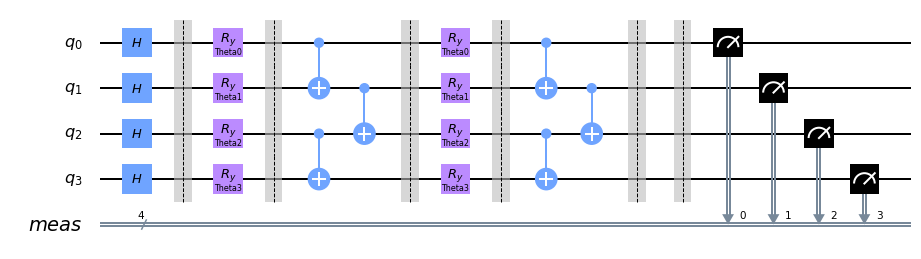

In [13]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl', filename='Figures/{}-qubit_circuit_conv.jpg'.format(NUM_QUBITS))

### TorchCircuit()

A pytorch layer always has two functions. One for the forward pass and one for the backward pass. The forward pass simply takes the Quantum Circuits variational parameters from the previous pytorch layer and runs the circuit on the defined hardware (defined in `QiskitCircuit.run()`) and returns the measurements from the quantum hardware.
These measurements will be the inputs of the next pytorch layer.

The backward pass returns the gradients of the quantum circuit. In this case here it is finite difference.

the `forward_tensor` is saved from the forward pass. So we just have to do one evaluation of the Q-Circuit in the backpass for the finite difference.

The `gradient` variable here is as well hard coded to 3 parameters. This should be updated in the future and made more general.

The loop `for k in range(len(input_numbers)):` goes through all the parameters (in this case 3), and shifts them by a small $\epsilon$. Then it runs the circuit and takes the diefferences of the ouput for the parameters $\Theta$ and $\Theta + \epsilon$. This is the finite difference. 

In [14]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result.to(device), i)
        
        return result
    
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
#         print('forward_tensor = {}'.format(forward_tensor))
        input_numbers = i.to(device)
#         print('input_numbers = {}'.format(input_numbers))
        gradients = torch.Tensor().to(device)
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
#             print('shift_right = {}, shift_left = {}'.format(shift_right, shift_left))
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
#             print('expectation_right = {}, \nexpectation_left = {}'.format(expectation_right, expectation_left))
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            # rescale gradient
#             gradient = gradient / torch.norm(gradient)
#             print('gradient for k={}: {}'.format(k, gradient))
            gradients = torch.cat((gradients, gradient.float().to(device)))
#         print(gradients)
            
        result = gradients.clone()
#         print('gradients = {}'.format(result))
#         print('grad_output = {}'.format(grad_output))

        ret = (result.float() * grad_output.to(device).float()).T.to(device)
#         print(ret)
        return ret

In [15]:
x = torch.tensor([np.pi/4]*NUM_QUBITS, requires_grad=True).to(device)

qc = TorchCircuit.apply
y1 = qc(x).to(device)
print('y1 after quantum layer: {}'.format(y1.float()))
y1 = nn.Linear(2**NUM_QUBITS,1).to(device)(y1.float()).to(device)
y1.backward()
print('x.grad = {}'.format(x.grad))

y1 after quantum layer: tensor([[0.0000, 0.0298, 0.0023, 0.2338, 0.0275, 0.2544, 0.0175, 0.0918, 0.0020,
         0.0505, 0.0000, 0.1829, 0.0158, 0.0867, 0.0050, 0.0000]],
       grad_fn=<CopyBackwards>)
x.grad = tensor([-0.0085, -0.0040, -0.0682, -0.0397])


In [16]:
x = torch.randn(3,4,5)

### Test the Quantum Circuit's Gradient Descent

First, we want the "neural net" consisting of just the quantum circuit (with its 4 inputs and 4 outputs) and a linear layer (from 4 inputs to 1 output) that scales measurement 1 by 1, measurement 2 by 2, etc., until it converges to a target value (-1). So, we define a cost function where the cost is defined as the square distance from the target value.

`x` is the initialization of the parameters. Here, every angle in the quantum circuit starts at $\pi/4$. We should see that the loss eventually goes down.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


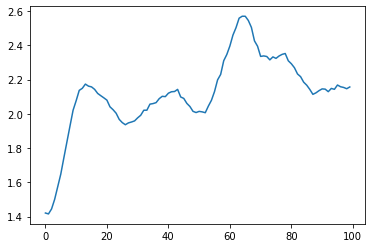

In [17]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    # simple linear layer: average all outputs of quantum layer
#     print(expval)
    val = sum([(i+1)*expval[i] for i in range(2**NUM_QUBITS)]) / 2**NUM_QUBITS
#     print(val)
    return torch.abs(val - target) ** 2, expval

x = torch.tensor([-np.pi/4]*NUM_QUBITS, requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)

plt.plot(loss_list)

### Load MNIST (0-1) Dataset

**Training Data**

In [18]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

NUM_CLASSES = 2
# Concentrating on the first 100 samples
n_samples = 150

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

n_samples = 200

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][n_samples:], 
                np.where(X_test.targets == 1)[0][n_samples:])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

### Define Neural Network with Q-node

This NN is  2 layers of ConvNN and a fully connected layer, with a Q-Node as a classifier.

In [22]:
NUM_CIRCUITS = 2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_CIRCUITS*NUM_QUBITS*2)
        self.qc = TorchCircuit.apply
        self.fc3 = nn.Linear(NUM_CIRCUITS * (2**NUM_QUBITS), NUM_CLASSES)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
#         x = np.pi*torch.tanh(x)
#         print('params to QC: {}'.format(x))
#         x = qc(x[0]) # QUANTUM LAYER
#         print('output of QC = {}'.format(x))
#         print(x)

        x = torch.tanh(x) # rescale to [-1, 1] to get sin(theta), cos(theta) for each angle
        x = x.view(-1) # flatten to 1D tensor
        x = torch.cat([(x[i * 2 : i*2 + NUM_QUBITS]) / torch.norm(x[i * 2: i*2 + 2]) 
                       for i in range(NUM_CIRCUITS*NUM_QUBITS)], dim=-1) # normalize sin and cos for each angle
        x = torch.stack([torch.atan2(x[i * 2], x[i*2 + 1]) for i in range(NUM_CIRCUITS*NUM_QUBITS)]) # convert to angles
        x = torch.cat([qc(x[i * 2 : i*2 + NUM_QUBITS]) for i in range(NUM_CIRCUITS)], dim=1) # QUANTUM LAYER

        x = torch.Tensor(x.float()).to(device)
        x = self.fc3(x)
#         print(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001)

# optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [24]:
epochs = 3
loss_list = []
loss_func = F.nll_loss

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, position=0, leave=True)):
        data, target = data.to(device), target.to(device)
#         print(batch_idx)
        optimizer.zero_grad()        
        # Forward pass
        output = network(data).to(device)
#         print(torch.argmax(output), target)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Training [33%]	Loss: 0.6866


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Training [67%]	Loss: 0.6436


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:44<00:00,  1.83it/s]

Training [100%]	Loss: 0.5159


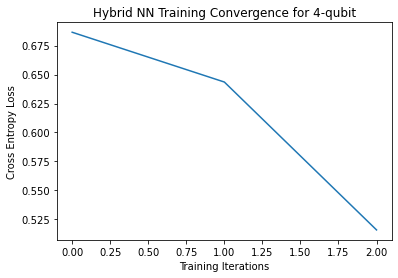

In [26]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.savefig('Figures/{}-qubit Loss Curve ryN.jpg'.format(NUM_QUBITS))

### Test accuracy of NN

The outcome is not always the same because the prediction is probabilistic.

In [27]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(tqdm(test_loader, position=0, leave=True)):
    number +=1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:08<00:00, 15.60it/s]


In [28]:
print("Performance on test data is is: {}/{} = {}%".format(accuracy,number,100*accuracy/number))    

Performance on test data is is: 397/2000 = 19.85%


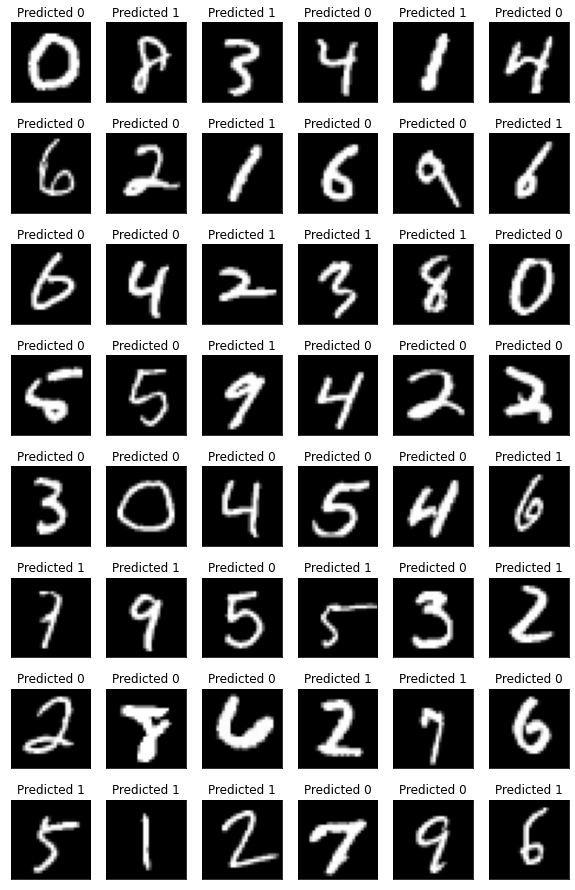

In [29]:
n_samples_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_samples_shape[0], ncols=n_samples_shape[1], figsize=(10, 2*n_samples_shape[0]))

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_shape[0]*n_samples_shape[1]:
            break
        pred = network.predict(data).item()

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_xticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_yticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_title('Predicted {}'.format(pred))
        
        count += 1

## MNIST 0-9

In [30]:
NUM_CLASSES = 10

n_samples = 150

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.stack([np.where(X_train.targets == i)[0][:n_samples] for i in range(10)], axis=1)
idx = idx.reshape(-1)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

n_samples = 200

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.stack([np.where(X_test.targets == i)[0][:n_samples] for i in range(10)])
idx = idx.reshape(-1)

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [31]:
NUM_CIRCUITS = 2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_CIRCUITS*NUM_QUBITS*2)
        self.qc = TorchCircuit.apply
        self.fc3 = nn.Linear(NUM_CIRCUITS * (2**NUM_QUBITS), NUM_CLASSES)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
#         x = np.pi*torch.tanh(x)
#         print('params to QC: {}'.format(x))
#         x = qc(x[0]) # QUANTUM LAYER
#         print('output of QC = {}'.format(x))
#         print(x)

        x = torch.tanh(x) # rescale to [-1, 1] to get sin(theta), cos(theta) for each angle
        x = x.view(-1) # flatten to 1D tensor
        x = torch.cat([(x[i * 2 : i*2 + NUM_QUBITS]) / torch.norm(x[i * 2: i*2 + 2]) 
                       for i in range(NUM_CIRCUITS*NUM_QUBITS)], dim=-1) # normalize sin and cos for each angle
        x = torch.stack([torch.atan2(x[i * 2], x[i*2 + 1]) for i in range(NUM_CIRCUITS*NUM_QUBITS)]) # convert to angles
        x = torch.cat([qc(x[i * 2 : i*2 + NUM_QUBITS]) for i in range(NUM_CIRCUITS)], dim=1) # QUANTUM LAYER

        x = torch.Tensor(x.float()).to(device)
        x = self.fc3(x)
#         print(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001)

# optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [32]:
epochs = 3
loss_list = []
loss_func = F.nll_loss

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, position=0, leave=True)):
        data, target = data.to(device), target.to(device)
#         print(batch_idx)
        optimizer.zero_grad()        
        # Forward pass
        output = network(data).to(device)
#         print(torch.argmax(output), target)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

Training [33%]	Loss: 2.3076


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

Training [67%]	Loss: 2.3065


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [14:04<00:00,  1.78it/s]

Training [100%]	Loss: 2.3068


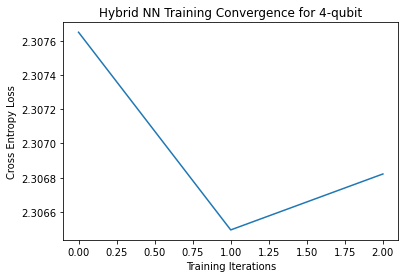

In [33]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.savefig('Figures/{}-qubit Loss Curve ryN.jpg'.format(NUM_QUBITS))

In [35]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(tqdm(test_loader, position=0, leave=True)):
    number +=1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1
    print(output)
    
print("Performance on test data is is: {}/{} = {}%".format(accuracy,number,100*accuracy/number))    

  0%|                                                                                 | 3/2000 [00:01<26:05,  1.28it/s]

7
6
1
8


  0%|▏                                                                                | 5/2000 [00:01<18:51,  1.76it/s]

2
5


  0%|▎                                                                                | 9/2000 [00:01<10:19,  3.21it/s]

2
8
1
9


  1%|▍                                                                               | 11/2000 [00:01<07:50,  4.23it/s]

2
9
7


  1%|▌                                                                               | 15/2000 [00:01<04:54,  6.73it/s]

7
7
2


  1%|▊                                                                               | 19/2000 [00:02<03:26,  9.58it/s]

6
7
6
2


  1%|▊                                                                               | 21/2000 [00:02<03:01, 10.91it/s]

8
6
2


  1%|█                                                                               | 25/2000 [00:02<02:31, 13.07it/s]

2
2
2


  1%|█                                                                               | 27/2000 [00:02<02:22, 13.83it/s]

8
7
1


  2%|█▏                                                                              | 31/2000 [00:02<02:11, 14.92it/s]

8
2
5


  2%|█▍                                                                              | 35/2000 [00:03<02:05, 15.61it/s]

5
2
7


  2%|█▍                                                                              | 37/2000 [00:03<02:04, 15.73it/s]

5
6
2
7


  2%|█▋                                                                              | 41/2000 [00:03<02:03, 15.90it/s]

5
2
7


  2%|█▋                                                                              | 43/2000 [00:03<02:05, 15.59it/s]

0
2
9

  2%|█▉                                                                              | 47/2000 [00:03<02:07, 15.37it/s]


2
2
7


  2%|█▉                                                                              | 49/2000 [00:04<02:05, 15.52it/s]

8
7
7


  3%|██                                                                              | 51/2000 [00:04<02:03, 15.78it/s]

3


  3%|██▏                                                                             | 55/2000 [00:04<02:29, 12.97it/s]

8
2
9
8


  3%|██▎                                                                             | 57/2000 [00:04<02:21, 13.72it/s]

0
6


  3%|██▍                                                                             | 61/2000 [00:05<02:17, 14.06it/s]

8
5
5


  3%|██▌                                                                             | 63/2000 [00:05<02:13, 14.56it/s]

2
2
6
7


  3%|██▌                                                                             | 65/2000 [00:05<02:09, 15.00it/s]

5


  3%|██▊                                                                             | 69/2000 [00:07<08:58,  3.59it/s]

8
7
3
7


  4%|██▊                                                                             | 71/2000 [00:07<06:52,  4.67it/s]

6
7
8


  4%|███                                                                             | 75/2000 [00:07<04:22,  7.33it/s]

7
6
6


  4%|███                                                                             | 77/2000 [00:08<03:39,  8.77it/s]

7
7
2


  4%|███▏                                                                            | 81/2000 [00:08<02:51, 11.18it/s]

7
9
7


  4%|███▎                                                                            | 83/2000 [00:08<02:36, 12.27it/s]

5
3
7


  4%|███▍                                                                            | 87/2000 [00:08<02:16, 13.98it/s]

2
2
2


  4%|███▌                                                                            | 89/2000 [00:08<02:12, 14.41it/s]

7
2
2


  5%|███▋                                                                            | 93/2000 [00:09<02:05, 15.24it/s]

7
2
0


  5%|███▉                                                                            | 97/2000 [00:09<02:08, 14.80it/s]

2
9
1


  5%|███▉                                                                           | 101/2000 [00:09<02:04, 15.21it/s]

5
7
6
8


  5%|████                                                                           | 103/2000 [00:09<02:04, 15.27it/s]

6
8
7
6


  5%|████▏                                                                          | 107/2000 [00:10<02:05, 15.10it/s]

2
5
8


  5%|████▎                                                                          | 109/2000 [00:10<02:02, 15.40it/s]

6
6
3


  6%|████▍                                                                          | 113/2000 [00:10<02:00, 15.72it/s]

7
1
1


  6%|████▌                                                                          | 115/2000 [00:10<01:59, 15.84it/s]

1
7
8


  6%|████▋                                                                          | 119/2000 [00:10<01:57, 15.99it/s]

7
6
5


  6%|████▊                                                                          | 121/2000 [00:10<01:58, 15.84it/s]

7
8
6

  6%|████▉                                                                          | 125/2000 [00:11<02:01, 15.40it/s]


2
6
8


  6%|█████                                                                          | 127/2000 [00:11<02:01, 15.43it/s]

1
8
2


  7%|█████▏                                                                         | 131/2000 [00:11<01:58, 15.78it/s]

8
7
5


  7%|█████▎                                                                         | 133/2000 [00:11<01:58, 15.70it/s]

7
2
1


  7%|█████▍                                                                         | 137/2000 [00:11<01:57, 15.89it/s]

2
6
2


  7%|█████▍                                                                         | 139/2000 [00:12<01:57, 15.81it/s]

6
6
9


  7%|█████▋                                                                         | 143/2000 [00:12<01:58, 15.71it/s]

9
7


  7%|█████▋                                                                         | 145/2000 [00:12<01:57, 15.76it/s]

2
8
2
3


  7%|█████▉                                                                         | 149/2000 [00:12<01:56, 15.92it/s]

2
2
7


  8%|█████▉                                                                         | 151/2000 [00:12<01:55, 15.94it/s]

7
2
2


  8%|██████                                                                         | 155/2000 [00:13<01:55, 16.04it/s]

2
2
2


  8%|██████▎                                                                        | 159/2000 [00:13<01:54, 16.10it/s]

2
7
2


  8%|██████▎                                                                        | 161/2000 [00:13<01:54, 16.03it/s]

7
7
7
7


  8%|██████▌                                                                        | 165/2000 [00:13<02:00, 15.27it/s]

5
3


  8%|██████▌                                                                        | 167/2000 [00:13<02:03, 14.86it/s]

3
5
7


  9%|██████▊                                                                        | 171/2000 [00:14<02:01, 15.02it/s]

6
2
9
2

  9%|██████▊                                                                        | 173/2000 [00:14<02:06, 14.47it/s]


8
8


  9%|██████▉                                                                        | 177/2000 [00:14<02:09, 14.06it/s]

6
2
2


  9%|███████                                                                        | 179/2000 [00:14<02:07, 14.31it/s]

1
1
2


  9%|███████▏                                                                       | 183/2000 [00:14<02:06, 14.40it/s]

7
1
2


  9%|███████▎                                                                       | 185/2000 [00:15<02:08, 14.15it/s]

9
1
7


  9%|███████▍                                                                       | 189/2000 [00:15<02:08, 14.08it/s]

6
3
1


 10%|███████▌                                                                       | 191/2000 [00:15<02:04, 14.57it/s]

2
2
3
6

 10%|███████▋                                                                       | 195/2000 [00:15<02:05, 14.39it/s]


6
2


 10%|███████▊                                                                       | 197/2000 [00:15<02:07, 14.09it/s]

3
8
2
8

 10%|███████▉                                                                       | 201/2000 [00:16<02:06, 14.22it/s]


9
6


 10%|████████                                                                       | 203/2000 [00:16<02:04, 14.40it/s]

1
8
7


 10%|████████▏                                                                      | 207/2000 [00:16<02:01, 14.75it/s]

7
6
3
8

 10%|████████▎                                                                      | 209/2000 [00:16<02:00, 14.80it/s]


7
1
6


 11%|████████▍                                                                      | 213/2000 [00:17<01:58, 15.14it/s]

8
7


 11%|████████▌                                                                      | 217/2000 [00:17<01:53, 15.64it/s]

2
2
6
8


 11%|████████▋                                                                      | 221/2000 [00:17<01:51, 15.90it/s]

5
2
7
5


 11%|████████▊                                                                      | 223/2000 [00:17<01:57, 15.14it/s]

7
7
2


 11%|████████▉                                                                      | 227/2000 [00:17<01:59, 14.85it/s]

7
1
8
1

 12%|█████████                                                                      | 231/2000 [00:18<01:57, 15.01it/s]


2
8
1


 12%|█████████▏                                                                     | 233/2000 [00:18<01:58, 14.85it/s]

2
7
8
7

 12%|█████████▎                                                                     | 237/2000 [00:18<01:59, 14.76it/s]


7
7


 12%|█████████▍                                                                     | 239/2000 [00:18<02:00, 14.61it/s]

9
5
7


 12%|█████████▌                                                                     | 243/2000 [00:19<02:00, 14.59it/s]

5
8
1


 12%|█████████▊                                                                     | 247/2000 [00:19<01:55, 15.14it/s]

7
6
1
8


 12%|█████████▊                                                                     | 249/2000 [00:19<01:59, 14.61it/s]

6
6
7
8


 13%|█████████▉                                                                     | 253/2000 [00:19<02:00, 14.46it/s]

2
7


 13%|██████████                                                                     | 255/2000 [00:19<02:01, 14.31it/s]

5
7
7


 13%|██████████▏                                                                    | 259/2000 [00:20<02:01, 14.38it/s]

0
5
8


 13%|██████████▎                                                                    | 261/2000 [00:20<02:03, 14.08it/s]

7
2
8


 13%|██████████▍                                                                    | 265/2000 [00:20<02:01, 14.23it/s]

2
9
6


 13%|██████████▌                                                                    | 267/2000 [00:20<02:00, 14.43it/s]

6
7
2


 14%|██████████▋                                                                    | 271/2000 [00:20<01:59, 14.44it/s]

2
1
7


 14%|██████████▊                                                                    | 273/2000 [00:21<01:59, 14.49it/s]

2
6
2
8


 14%|██████████▉                                                                    | 277/2000 [00:21<01:53, 15.17it/s]

2
1
7


 14%|███████████                                                                    | 281/2000 [00:21<01:49, 15.70it/s]

1
2
7


 14%|███████████▏                                                                   | 283/2000 [00:21<01:49, 15.71it/s]

9
9
1
2


 14%|███████████▎                                                                   | 287/2000 [00:21<01:48, 15.78it/s]

6
2
8


 14%|███████████▍                                                                   | 289/2000 [00:22<01:47, 15.89it/s]

7
7
2


 15%|███████████▌                                                                   | 293/2000 [00:22<01:49, 15.55it/s]

6
6


 15%|███████████▋                                                                   | 295/2000 [00:22<01:51, 15.25it/s]

7
8
5


 15%|███████████▊                                                                   | 299/2000 [00:22<01:52, 15.05it/s]

6
8
8


 15%|███████████▉                                                                   | 301/2000 [00:22<02:04, 13.66it/s]

5
9
1


 15%|████████████                                                                   | 305/2000 [00:23<01:56, 14.60it/s]

7
2
6
2

 15%|████████████▏                                                                  | 307/2000 [00:23<01:53, 14.96it/s]


6
2
2


 16%|████████████▎                                                                  | 311/2000 [00:23<01:49, 15.38it/s]

7
2


 16%|████████████▎                                                                  | 313/2000 [00:23<01:48, 15.56it/s]

2
8
1
8


 16%|████████████▌                                                                  | 317/2000 [00:23<01:48, 15.52it/s]

8
7
2

 16%|████████████▌                                                                  | 319/2000 [00:24<01:49, 15.30it/s]


8
8
5


 16%|████████████▊                                                                  | 323/2000 [00:24<01:47, 15.60it/s]

7
6
7


 16%|████████████▊                                                                  | 325/2000 [00:24<01:46, 15.72it/s]

5
9
1


 16%|████████████▉                                                                  | 329/2000 [00:24<01:45, 15.78it/s]

6
7
0


 17%|█████████████                                                                  | 331/2000 [00:24<01:47, 15.48it/s]

2
8


 17%|█████████████▏                                                                 | 335/2000 [00:25<01:50, 15.03it/s]

6
2
7


 17%|█████████████▎                                                                 | 337/2000 [00:25<01:50, 15.07it/s]

2
8
7
3


 17%|█████████████▍                                                                 | 341/2000 [00:25<01:48, 15.35it/s]

7
2


 17%|█████████████▌                                                                 | 343/2000 [00:25<01:48, 15.26it/s]

7
3
7
1


 17%|█████████████▋                                                                 | 347/2000 [00:25<01:48, 15.21it/s]

0
3


 17%|█████████████▊                                                                 | 349/2000 [00:26<01:48, 15.19it/s]

5
1
8


 18%|█████████████▉                                                                 | 353/2000 [00:26<01:49, 15.10it/s]

6
2
8
8

 18%|██████████████                                                                 | 355/2000 [00:26<01:47, 15.25it/s]


8
6
8


 18%|██████████████▏                                                                | 359/2000 [00:26<01:45, 15.62it/s]

5
2
6


 18%|██████████████▎                                                                | 363/2000 [00:26<01:53, 14.40it/s]

7
2
2


 18%|██████████████▍                                                                | 365/2000 [00:27<01:51, 14.62it/s]

8
3
2
2


 18%|██████████████▌                                                                | 369/2000 [00:27<01:48, 15.05it/s]

9
7
3


 19%|██████████████▋                                                                | 371/2000 [00:27<01:46, 15.32it/s]

2
8
7


 19%|██████████████▊                                                                | 375/2000 [00:27<01:47, 15.11it/s]

6
6


 19%|██████████████▉                                                                | 377/2000 [00:27<01:47, 15.16it/s]

2
6
1
9


 19%|███████████████                                                                | 381/2000 [00:28<01:44, 15.47it/s]

2
7
2


 19%|███████████████▏                                                               | 385/2000 [00:28<01:42, 15.77it/s]

2
2
7


 19%|███████████████▎                                                               | 387/2000 [00:28<01:42, 15.77it/s]

2
1
7
2


 20%|███████████████▍                                                               | 391/2000 [00:28<01:41, 15.90it/s]

6
7
1


 20%|███████████████▌                                                               | 393/2000 [00:28<01:42, 15.75it/s]

2
2
6

 20%|███████████████▋                                                               | 397/2000 [00:29<01:43, 15.54it/s]


8
8
2


 20%|███████████████▊                                                               | 399/2000 [00:29<01:46, 15.04it/s]

6
1


 20%|███████████████▉                                                               | 403/2000 [00:29<01:46, 15.02it/s]

2
7
6
3

 20%|███████████████▉                                                               | 405/2000 [00:29<01:46, 14.96it/s]


1
7
2


 20%|████████████████▏                                                              | 409/2000 [00:29<01:45, 15.06it/s]

1
1
6
2


 21%|████████████████▎                                                              | 413/2000 [00:30<01:44, 15.13it/s]

0
6


 21%|████████████████▍                                                              | 417/2000 [00:30<01:42, 15.47it/s]

7
3
2
2


 21%|████████████████▌                                                              | 419/2000 [00:30<01:41, 15.55it/s]

6
9
2
8


 21%|████████████████▋                                                              | 423/2000 [00:30<01:42, 15.42it/s]

2
7


 21%|████████████████▊                                                              | 425/2000 [00:31<01:42, 15.34it/s]

6
6
9
2


 21%|████████████████▉                                                              | 429/2000 [00:31<01:41, 15.50it/s]

1
7


 22%|█████████████████                                                              | 431/2000 [00:31<01:41, 15.50it/s]

5
7
7
2


 22%|█████████████████▏                                                             | 435/2000 [00:31<01:38, 15.84it/s]

7
7
7


 22%|█████████████████▎                                                             | 439/2000 [00:31<01:37, 15.98it/s]

5
7
2
6


 22%|█████████████████▍                                                             | 441/2000 [00:32<01:37, 15.95it/s]

8
7
8


 22%|█████████████████▌                                                             | 445/2000 [00:32<01:37, 16.03it/s]

5
2
8


 22%|█████████████████▋                                                             | 447/2000 [00:32<01:38, 15.79it/s]

2
5
8


 23%|█████████████████▊                                                             | 451/2000 [00:32<01:37, 15.87it/s]

1
7
2


 23%|█████████████████▉                                                             | 453/2000 [00:32<01:36, 15.95it/s]

1
3
1


 23%|██████████████████                                                             | 457/2000 [00:33<01:37, 15.84it/s]

8
2
7

 23%|██████████████████▏                                                            | 459/2000 [00:33<01:43, 14.93it/s]


7
2


 23%|██████████████████▎                                                            | 463/2000 [00:33<01:42, 15.06it/s]

6
1
2
6


 23%|██████████████████▎                                                            | 465/2000 [00:33<01:40, 15.23it/s]

8
7
2


 23%|██████████████████▌                                                            | 469/2000 [00:33<01:37, 15.67it/s]

7
7
7


 24%|██████████████████▌                                                            | 471/2000 [00:33<01:37, 15.65it/s]

7
8
6


 24%|██████████████████▊                                                            | 475/2000 [00:34<01:36, 15.83it/s]

8
2
7


 24%|██████████████████▊                                                            | 477/2000 [00:34<01:35, 15.92it/s]

7
9
3


 24%|██████████████████▉                                                            | 481/2000 [00:34<01:34, 16.06it/s]

7
2
7


 24%|███████████████████                                                            | 483/2000 [00:34<01:35, 15.96it/s]

7
3
9


 24%|███████████████████▏                                                           | 487/2000 [00:34<01:39, 15.28it/s]

2
8


 24%|███████████████████▎                                                           | 489/2000 [00:35<01:41, 14.93it/s]

5
8
2
2


 25%|███████████████████▍                                                           | 493/2000 [00:35<01:38, 15.34it/s]

3
2
2


 25%|███████████████████▌                                                           | 495/2000 [00:35<01:37, 15.50it/s]

6
3
7


 25%|███████████████████▋                                                           | 499/2000 [00:35<01:35, 15.67it/s]

2
3


 25%|███████████████████▊                                                           | 501/2000 [00:35<01:37, 15.37it/s]

3
5
6
2


 25%|███████████████████▉                                                           | 505/2000 [00:36<01:36, 15.43it/s]

6
7


 25%|████████████████████                                                           | 507/2000 [00:36<01:36, 15.46it/s]

6
2
1
8


 26%|████████████████████▏                                                          | 511/2000 [00:36<01:35, 15.57it/s]

6
7
6


 26%|████████████████████▎                                                          | 513/2000 [00:36<01:34, 15.73it/s]

7
8
1


 26%|████████████████████▍                                                          | 517/2000 [00:36<01:34, 15.77it/s]

7
5
7


 26%|████████████████████▌                                                          | 521/2000 [00:37<01:32, 15.95it/s]

2
7
6


 26%|████████████████████▋                                                          | 523/2000 [00:37<01:32, 16.01it/s]

7
2
8
2


 26%|████████████████████▊                                                          | 527/2000 [00:37<01:32, 15.97it/s]

8
7
7


 26%|████████████████████▉                                                          | 529/2000 [00:37<01:32, 15.98it/s]

2
2
8


 27%|█████████████████████                                                          | 533/2000 [00:37<01:32, 15.94it/s]

7
6
1


 27%|█████████████████████▏                                                         | 535/2000 [00:38<01:34, 15.44it/s]

6
2
8


 27%|█████████████████████▎                                                         | 539/2000 [00:38<01:33, 15.59it/s]

7
2


 27%|█████████████████████▎                                                         | 541/2000 [00:38<01:33, 15.64it/s]

7
7
8
7


 27%|█████████████████████▌                                                         | 545/2000 [00:38<01:33, 15.57it/s]

2
1
2

 27%|█████████████████████▌                                                         | 547/2000 [00:38<01:33, 15.48it/s]


3
3
7


 28%|█████████████████████▊                                                         | 551/2000 [00:39<01:33, 15.57it/s]

2
2
9


 28%|█████████████████████▊                                                         | 553/2000 [00:39<01:33, 15.48it/s]

8
9


 28%|██████████████████████                                                         | 557/2000 [00:39<01:34, 15.21it/s]

1
1
6


 28%|██████████████████████                                                         | 559/2000 [00:39<01:34, 15.23it/s]

7
1
2
8


 28%|██████████████████████▏                                                        | 563/2000 [00:39<01:31, 15.64it/s]

2
6
2


 28%|██████████████████████▎                                                        | 565/2000 [00:39<01:33, 15.39it/s]

2
6


 28%|██████████████████████▍                                                        | 569/2000 [00:40<01:33, 15.28it/s]

2
1
5
8


 29%|██████████████████████▌                                                        | 571/2000 [00:40<01:32, 15.45it/s]

5
7
1


 29%|██████████████████████▋                                                        | 575/2000 [00:40<01:40, 14.17it/s]

3
5
6


 29%|██████████████████████▊                                                        | 579/2000 [00:40<01:37, 14.61it/s]

5
1
6
6


 29%|██████████████████████▉                                                        | 581/2000 [00:41<01:36, 14.68it/s]

2
5
2


 29%|███████████████████████                                                        | 585/2000 [00:41<01:32, 15.36it/s]

2
1
8


 29%|███████████████████████▏                                                       | 587/2000 [00:41<01:31, 15.51it/s]

6
1
7


 30%|███████████████████████▎                                                       | 591/2000 [00:41<01:28, 15.83it/s]

2
8
2


 30%|███████████████████████▍                                                       | 593/2000 [00:41<01:29, 15.70it/s]

7
6
6

 30%|███████████████████████▌                                                       | 597/2000 [00:42<01:29, 15.76it/s]


7
2
1


 30%|███████████████████████▋                                                       | 599/2000 [00:42<01:28, 15.84it/s]

2
9
6


 30%|███████████████████████▊                                                       | 603/2000 [00:42<01:28, 15.78it/s]

8
7
2
8


 30%|███████████████████████▉                                                       | 607/2000 [00:42<01:28, 15.83it/s]

6
6
5


 30%|████████████████████████                                                       | 609/2000 [00:42<01:29, 15.62it/s]

4
5
7

 31%|████████████████████████▏                                                      | 613/2000 [00:43<01:29, 15.48it/s]


6
2
8


 31%|████████████████████████▎                                                      | 615/2000 [00:43<01:28, 15.56it/s]

2
2
8

 31%|████████████████████████▍                                                      | 619/2000 [00:43<01:29, 15.40it/s]


7
9
7


 31%|████████████████████████▌                                                      | 621/2000 [00:43<01:29, 15.43it/s]

7
1
8


 31%|████████████████████████▋                                                      | 625/2000 [00:43<01:26, 15.84it/s]

2
2
8


 31%|████████████████████████▊                                                      | 627/2000 [00:43<01:26, 15.81it/s]

8
1
7


 32%|████████████████████████▉                                                      | 631/2000 [00:44<01:25, 15.92it/s]

8
2
1


 32%|█████████████████████████                                                      | 633/2000 [00:44<01:25, 15.95it/s]

2
1
2


 32%|█████████████████████████▏                                                     | 637/2000 [00:44<01:24, 16.11it/s]

5
3
7


 32%|█████████████████████████▏                                                     | 639/2000 [00:44<01:24, 16.08it/s]

1
2
8


 32%|█████████████████████████▍                                                     | 643/2000 [00:44<01:25, 15.83it/s]

2
7
5

 32%|█████████████████████████▍                                                     | 645/2000 [00:45<01:26, 15.59it/s]


3
7
6


 32%|█████████████████████████▋                                                     | 649/2000 [00:45<01:24, 15.93it/s]

2
7
7


 33%|█████████████████████████▊                                                     | 653/2000 [00:45<01:24, 15.97it/s]

7
1
8
7


 33%|█████████████████████████▊                                                     | 655/2000 [00:45<01:24, 15.83it/s]

2
2


 33%|██████████████████████████                                                     | 659/2000 [00:45<01:26, 15.48it/s]

2
7
7
6

 33%|██████████████████████████                                                     | 661/2000 [00:46<01:26, 15.49it/s]


7
2
6


 33%|██████████████████████████▎                                                    | 665/2000 [00:46<01:24, 15.77it/s]

1
7
6


 33%|██████████████████████████▎                                                    | 667/2000 [00:46<01:24, 15.84it/s]

7
2
2


 34%|██████████████████████████▌                                                    | 671/2000 [00:46<01:23, 15.91it/s]

5
6
6


 34%|██████████████████████████▌                                                    | 673/2000 [00:46<01:23, 15.94it/s]

2
2
7


 34%|██████████████████████████▋                                                    | 677/2000 [00:47<01:22, 16.08it/s]

7
2
5


 34%|██████████████████████████▉                                                    | 681/2000 [00:47<01:22, 16.04it/s]

7
2
8
2


 34%|██████████████████████████▉                                                    | 683/2000 [00:47<01:22, 16.03it/s]

1
1
6


 34%|███████████████████████████▏                                                   | 687/2000 [00:47<01:21, 16.04it/s]

6
1
5


 34%|███████████████████████████▏                                                   | 689/2000 [00:47<01:21, 16.03it/s]

6
7
1


 35%|███████████████████████████▎                                                   | 693/2000 [00:48<01:21, 16.08it/s]

6
9
9


 35%|███████████████████████████▍                                                   | 695/2000 [00:48<01:21, 15.95it/s]

3
3


 35%|███████████████████████████▌                                                   | 699/2000 [00:48<01:26, 15.12it/s]

2
1
1
1


 35%|███████████████████████████▋                                                   | 701/2000 [00:48<01:24, 15.34it/s]

8
7
6


 35%|███████████████████████████▊                                                   | 705/2000 [00:48<01:22, 15.71it/s]

8
7
2


 35%|███████████████████████████▉                                                   | 707/2000 [00:49<01:22, 15.69it/s]

6
8
2


 36%|████████████████████████████                                                   | 711/2000 [00:49<01:21, 15.91it/s]

7
7
7


 36%|████████████████████████████▏                                                  | 713/2000 [00:49<01:21, 15.86it/s]

6
9
7


 36%|████████████████████████████▎                                                  | 717/2000 [00:49<01:20, 15.90it/s]

2
0
2


 36%|████████████████████████████▍                                                  | 719/2000 [00:49<01:20, 15.82it/s]

6
4
1


 36%|████████████████████████████▌                                                  | 723/2000 [00:50<01:22, 15.46it/s]

2
2


 36%|████████████████████████████▋                                                  | 725/2000 [00:50<01:24, 15.06it/s]

5
1
2


 36%|████████████████████████████▊                                                  | 729/2000 [00:50<01:22, 15.45it/s]

8
7
2
2


 37%|████████████████████████████▊                                                  | 731/2000 [00:50<01:21, 15.51it/s]

5
1
5


 37%|█████████████████████████████                                                  | 735/2000 [00:50<01:19, 15.82it/s]

2
2
9


 37%|█████████████████████████████                                                  | 737/2000 [00:50<01:21, 15.43it/s]

7
6


 37%|█████████████████████████████▎                                                 | 741/2000 [00:51<01:20, 15.60it/s]

8
8
9
7


 37%|█████████████████████████████▎                                                 | 743/2000 [00:51<01:21, 15.50it/s]

2
7
9


 37%|█████████████████████████████▌                                                 | 747/2000 [00:51<01:20, 15.64it/s]

8
1
7


 37%|█████████████████████████████▌                                                 | 749/2000 [00:51<01:19, 15.64it/s]

2
7
8


 38%|█████████████████████████████▋                                                 | 753/2000 [00:51<01:19, 15.70it/s]

2
1
7


 38%|█████████████████████████████▊                                                 | 755/2000 [00:52<01:19, 15.64it/s]

6
1
6


 38%|█████████████████████████████▉                                                 | 759/2000 [00:52<01:18, 15.83it/s]

7
6
5


 38%|██████████████████████████████                                                 | 761/2000 [00:52<01:18, 15.84it/s]

7
1
6


 38%|██████████████████████████████▏                                                | 765/2000 [00:52<01:17, 15.95it/s]

7
6
7


 38%|██████████████████████████████▎                                                | 767/2000 [00:52<01:17, 15.89it/s]

8
1
7


 39%|██████████████████████████████▍                                                | 771/2000 [00:53<01:16, 15.98it/s]

7
8
7


 39%|██████████████████████████████▌                                                | 773/2000 [00:53<01:16, 15.95it/s]

6
7
8


 39%|██████████████████████████████▋                                                | 777/2000 [00:53<01:16, 16.04it/s]

6
7
6


 39%|██████████████████████████████▊                                                | 779/2000 [00:53<01:16, 15.99it/s]

7
2
1


 39%|██████████████████████████████▉                                                | 783/2000 [00:53<01:16, 15.99it/s]

2
6
8

 39%|███████████████████████████████                                                | 785/2000 [00:53<01:16, 15.88it/s]


9
1
1


 39%|███████████████████████████████▏                                               | 789/2000 [00:54<01:17, 15.65it/s]

7
7
6


 40%|███████████████████████████████▏                                               | 791/2000 [00:54<01:18, 15.43it/s]

7
6


 40%|███████████████████████████████▍                                               | 795/2000 [00:54<01:17, 15.59it/s]

6
7
7
3


 40%|███████████████████████████████▍                                               | 797/2000 [00:54<01:17, 15.60it/s]

1
8


 40%|███████████████████████████████▋                                               | 801/2000 [00:55<01:19, 15.08it/s]

7
8
6


 40%|███████████████████████████████▊                                               | 805/2000 [00:55<01:18, 15.26it/s]

6
6
8
8


 40%|███████████████████████████████▉                                               | 807/2000 [00:55<01:18, 15.26it/s]

1
2
7
9


 41%|████████████████████████████████                                               | 811/2000 [00:55<01:17, 15.43it/s]

7
1
2


 41%|████████████████████████████████                                               | 813/2000 [00:55<01:16, 15.52it/s]

2
5
6

 41%|████████████████████████████████▎                                              | 817/2000 [00:56<01:16, 15.46it/s]


8
8
6


 41%|████████████████████████████████▎                                              | 819/2000 [00:56<01:16, 15.51it/s]

2
2
7


 41%|████████████████████████████████▌                                              | 823/2000 [00:56<01:15, 15.61it/s]

7
2
2


 41%|████████████████████████████████▋                                              | 827/2000 [00:56<01:16, 15.36it/s]

7
7
6
7


 41%|████████████████████████████████▋                                              | 829/2000 [00:56<01:16, 15.33it/s]

5
6
2

 42%|████████████████████████████████▉                                              | 833/2000 [00:57<01:14, 15.70it/s]


2
8
3

 42%|████████████████████████████████▉                                              | 835/2000 [00:57<01:14, 15.61it/s]


6
7
7


 42%|█████████████████████████████████▏                                             | 839/2000 [00:57<01:15, 15.31it/s]

7
1


 42%|█████████████████████████████████▏                                             | 841/2000 [00:57<01:15, 15.33it/s]

2
5
2
1


 42%|█████████████████████████████████▍                                             | 845/2000 [00:57<01:15, 15.24it/s]

2
6


 42%|█████████████████████████████████▍                                             | 847/2000 [00:58<01:17, 14.94it/s]

1
7
7


 43%|█████████████████████████████████▌                                             | 851/2000 [00:58<01:15, 15.23it/s]

1
2
8
2

 43%|█████████████████████████████████▋                                             | 853/2000 [00:58<01:15, 15.17it/s]


7
4
1


 43%|█████████████████████████████████▊                                             | 857/2000 [00:58<01:13, 15.52it/s]

1
1
2


 43%|█████████████████████████████████▉                                             | 859/2000 [00:58<01:14, 15.27it/s]

6
6


 43%|██████████████████████████████████                                             | 863/2000 [00:59<01:14, 15.19it/s]

9
1
1


 43%|██████████████████████████████████▏                                            | 865/2000 [00:59<01:14, 15.32it/s]

2
7
9
2


 43%|██████████████████████████████████▎                                            | 869/2000 [00:59<01:12, 15.70it/s]

2
6
2


 44%|██████████████████████████████████▍                                            | 871/2000 [00:59<01:12, 15.60it/s]

6
1
7


 44%|██████████████████████████████████▌                                            | 875/2000 [00:59<01:11, 15.67it/s]

3
3
2

 44%|██████████████████████████████████▋                                            | 877/2000 [00:59<01:12, 15.48it/s]


5
8
8


 44%|██████████████████████████████████▊                                            | 881/2000 [01:00<01:14, 15.08it/s]

6
9


 44%|██████████████████████████████████▉                                            | 883/2000 [01:00<01:16, 14.60it/s]

7
7
2
7

 44%|███████████████████████████████████                                            | 887/2000 [01:00<01:13, 15.24it/s]


6
7
7


 44%|███████████████████████████████████                                            | 889/2000 [01:00<01:12, 15.36it/s]

8
1
7


 45%|███████████████████████████████████▎                                           | 893/2000 [01:00<01:10, 15.63it/s]

6
6
2


 45%|███████████████████████████████████▎                                           | 895/2000 [01:01<01:11, 15.56it/s]

8
2
8

 45%|███████████████████████████████████▌                                           | 899/2000 [01:01<01:10, 15.58it/s]


7
7
7


 45%|███████████████████████████████████▌                                           | 901/2000 [01:01<01:10, 15.60it/s]

7
2
2

 45%|███████████████████████████████████▋                                           | 905/2000 [01:01<01:11, 15.35it/s]


8
7
2


 45%|███████████████████████████████████▊                                           | 907/2000 [01:01<01:10, 15.43it/s]

1
6
8


 46%|███████████████████████████████████▉                                           | 911/2000 [01:02<01:10, 15.50it/s]

7
2


 46%|████████████████████████████████████                                           | 913/2000 [01:02<01:10, 15.46it/s]

8
2
6
1


 46%|████████████████████████████████████▏                                          | 917/2000 [01:02<01:08, 15.77it/s]

8
2
2


 46%|████████████████████████████████████▍                                          | 921/2000 [01:02<01:08, 15.77it/s]

7
2
2


 46%|████████████████████████████████████▍                                          | 923/2000 [01:02<01:08, 15.73it/s]

6
8
2
8


 46%|████████████████████████████████████▌                                          | 927/2000 [01:03<01:07, 15.78it/s]

7
6
2


 46%|████████████████████████████████████▋                                          | 929/2000 [01:03<01:07, 15.81it/s]

2
6
2


 47%|████████████████████████████████████▊                                          | 933/2000 [01:03<01:06, 15.95it/s]

2
6
2


 47%|████████████████████████████████████▉                                          | 935/2000 [01:03<01:06, 15.96it/s]

7
0
5


 47%|█████████████████████████████████████                                          | 939/2000 [01:03<01:06, 15.96it/s]

7
2
7

 47%|█████████████████████████████████████▏                                         | 941/2000 [01:04<01:07, 15.78it/s]


7
8
2


 47%|█████████████████████████████████████▏                                         | 943/2000 [01:04<01:07, 15.59it/s]

8


 47%|█████████████████████████████████████▍                                         | 947/2000 [01:04<01:17, 13.52it/s]

3
7
7
2


 47%|█████████████████████████████████████▍                                         | 949/2000 [01:04<01:14, 14.03it/s]

6
5
6

 48%|█████████████████████████████████████▋                                         | 953/2000 [01:04<01:13, 14.32it/s]


7
6


 48%|█████████████████████████████████████▋                                         | 955/2000 [01:05<01:14, 14.07it/s]

7
2
8


 48%|█████████████████████████████████████▉                                         | 959/2000 [01:05<01:10, 14.84it/s]

8
1
8
2


 48%|█████████████████████████████████████▉                                         | 961/2000 [01:05<01:08, 15.11it/s]

8
2
7

 48%|██████████████████████████████████████                                         | 965/2000 [01:05<01:06, 15.56it/s]


7
8
2


 48%|██████████████████████████████████████▎                                        | 969/2000 [01:05<01:05, 15.67it/s]

4
3
5


 49%|██████████████████████████████████████▎                                        | 971/2000 [01:06<01:05, 15.62it/s]

1
2
2
7


 49%|██████████████████████████████████████▌                                        | 975/2000 [01:06<01:04, 15.84it/s]

7
9
1


 49%|██████████████████████████████████████▌                                        | 977/2000 [01:06<01:04, 15.89it/s]

7
1
1


 49%|██████████████████████████████████████▋                                        | 981/2000 [01:06<01:03, 15.95it/s]

8
8
6


 49%|██████████████████████████████████████▊                                        | 983/2000 [01:06<01:04, 15.78it/s]

7
2
2


 49%|██████████████████████████████████████▉                                        | 987/2000 [01:07<01:07, 14.91it/s]

2
6


 49%|███████████████████████████████████████                                        | 989/2000 [01:07<01:15, 13.31it/s]

7
6
8


 50%|███████████████████████████████████████▏                                       | 993/2000 [01:07<01:11, 14.05it/s]

1
5
7
3

 50%|███████████████████████████████████████▎                                       | 995/2000 [01:07<01:09, 14.40it/s]


5
2
6


 50%|███████████████████████████████████████▍                                       | 999/2000 [01:07<01:08, 14.72it/s]

6
7


 50%|███████████████████████████████████████                                       | 1001/2000 [01:08<01:07, 14.85it/s]

2
2
9
7


 50%|███████████████████████████████████████▏                                      | 1005/2000 [01:08<01:04, 15.32it/s]

6
6
2


 50%|███████████████████████████████████████▎                                      | 1009/2000 [01:08<01:05, 15.22it/s]

1
9
7
2

 51%|███████████████████████████████████████▍                                      | 1011/2000 [01:08<01:05, 15.07it/s]


5
5
2


 51%|███████████████████████████████████████▌                                      | 1015/2000 [01:09<01:04, 15.24it/s]

7
6


 51%|███████████████████████████████████████▋                                      | 1017/2000 [01:09<01:04, 15.32it/s]

7
2
5
7


 51%|███████████████████████████████████████▊                                      | 1021/2000 [01:09<01:03, 15.51it/s]

2
7
2


 51%|███████████████████████████████████████▉                                      | 1025/2000 [01:09<01:02, 15.58it/s]

8
5
2
2


 51%|████████████████████████████████████████                                      | 1027/2000 [01:09<01:03, 15.38it/s]

5
6


 52%|████████████████████████████████████████▏                                     | 1031/2000 [01:10<01:04, 14.94it/s]

8
1
1


 52%|████████████████████████████████████████▎                                     | 1033/2000 [01:10<01:03, 15.21it/s]

2
2
7
3


 52%|████████████████████████████████████████▍                                     | 1037/2000 [01:10<01:02, 15.45it/s]

6
6
6

 52%|████████████████████████████████████████▌                                     | 1039/2000 [01:10<01:02, 15.36it/s]


8
6
8


 52%|████████████████████████████████████████▋                                     | 1043/2000 [01:10<01:03, 15.19it/s]

1
7


 52%|████████████████████████████████████████▊                                     | 1045/2000 [01:11<01:02, 15.21it/s]

5
7
8
6


 52%|████████████████████████████████████████▉                                     | 1049/2000 [01:11<01:02, 15.11it/s]

3
2


 53%|████████████████████████████████████████▉                                     | 1051/2000 [01:11<01:05, 14.56it/s]

7
8
2


 53%|█████████████████████████████████████████▏                                    | 1055/2000 [01:11<01:03, 14.95it/s]

2
1
9
7


 53%|█████████████████████████████████████████▏                                    | 1057/2000 [01:11<01:02, 15.08it/s]

8
2
2


 53%|█████████████████████████████████████████▍                                    | 1061/2000 [01:12<01:01, 15.36it/s]

2
2


 53%|█████████████████████████████████████████▍                                    | 1063/2000 [01:12<01:03, 14.69it/s]

7
5
6
5


 53%|█████████████████████████████████████████▌                                    | 1067/2000 [01:12<01:02, 14.87it/s]

6
6


 53%|█████████████████████████████████████████▋                                    | 1069/2000 [01:12<01:02, 14.92it/s]

1
7
2
2


 54%|█████████████████████████████████████████▊                                    | 1073/2000 [01:12<01:01, 15.07it/s]

7
7


 54%|█████████████████████████████████████████▉                                    | 1075/2000 [01:13<01:00, 15.23it/s]

5
9
2
8

 54%|██████████████████████████████████████████                                    | 1079/2000 [01:13<01:00, 15.29it/s]


9
8
7


 54%|██████████████████████████████████████████▏                                   | 1081/2000 [01:13<00:59, 15.39it/s]

9
6
1


 54%|██████████████████████████████████████████▎                                   | 1085/2000 [01:13<00:58, 15.72it/s]

8
6
7


 54%|██████████████████████████████████████████▍                                   | 1089/2000 [01:13<00:58, 15.68it/s]

6
3
2


 55%|██████████████████████████████████████████▌                                   | 1091/2000 [01:14<00:58, 15.44it/s]

7
6
2
7


 55%|██████████████████████████████████████████▋                                   | 1095/2000 [01:14<00:58, 15.40it/s]

6
7


 55%|██████████████████████████████████████████▊                                   | 1097/2000 [01:14<00:58, 15.47it/s]

3
9
1
7


 55%|██████████████████████████████████████████▉                                   | 1101/2000 [01:14<00:58, 15.40it/s]

1
7


 55%|███████████████████████████████████████████                                   | 1103/2000 [01:14<00:58, 15.36it/s]

1
8
8


 55%|███████████████████████████████████████████▏                                  | 1107/2000 [01:15<01:03, 14.14it/s]

2
8
2


 55%|███████████████████████████████████████████▎                                  | 1109/2000 [01:15<01:01, 14.43it/s]

7
6
7


 56%|███████████████████████████████████████████▍                                  | 1113/2000 [01:15<00:59, 14.95it/s]

2
7
2
2

 56%|███████████████████████████████████████████▍                                  | 1115/2000 [01:15<00:58, 15.01it/s]


8
8
9


 56%|███████████████████████████████████████████▋                                  | 1119/2000 [01:15<00:57, 15.30it/s]

7
6
7


 56%|███████████████████████████████████████████▊                                  | 1123/2000 [01:16<00:55, 15.67it/s]

9
7
7
2


 56%|███████████████████████████████████████████▉                                  | 1125/2000 [01:16<00:56, 15.62it/s]

3
1
7


 56%|████████████████████████████████████████████                                  | 1129/2000 [01:16<00:55, 15.79it/s]

9
6
2


 57%|████████████████████████████████████████████                                  | 1131/2000 [01:16<00:55, 15.78it/s]

2
2
2


 57%|████████████████████████████████████████████▎                                 | 1135/2000 [01:16<00:54, 15.83it/s]

1
1
7

 57%|████████████████████████████████████████████▍                                 | 1139/2000 [01:17<00:53, 15.97it/s]


3
7
7


 57%|████████████████████████████████████████████▍                                 | 1141/2000 [01:17<00:53, 15.94it/s]

6
8
6
7


 57%|████████████████████████████████████████████▋                                 | 1145/2000 [01:17<00:53, 15.85it/s]

3
9
6


 57%|████████████████████████████████████████████▊                                 | 1149/2000 [01:17<00:54, 15.69it/s]

7
8
2
1

 58%|████████████████████████████████████████████▉                                 | 1151/2000 [01:17<00:57, 14.64it/s]


8
8


 58%|█████████████████████████████████████████████                                 | 1155/2000 [01:18<00:55, 15.24it/s]

6
7
9


 58%|█████████████████████████████████████████████                                 | 1157/2000 [01:18<00:55, 15.28it/s]

8
2
2
6


 58%|█████████████████████████████████████████████▎                                | 1161/2000 [01:18<00:54, 15.53it/s]

2
7
9


 58%|█████████████████████████████████████████████▎                                | 1163/2000 [01:18<00:53, 15.60it/s]

5
8
6


 58%|█████████████████████████████████████████████▌                                | 1167/2000 [01:18<00:53, 15.72it/s]

7
8
5


 58%|█████████████████████████████████████████████▌                                | 1169/2000 [01:19<00:53, 15.65it/s]

1
3
8


 59%|█████████████████████████████████████████████▋                                | 1173/2000 [01:19<00:52, 15.83it/s]

7
7
2


 59%|█████████████████████████████████████████████▉                                | 1177/2000 [01:19<00:51, 15.89it/s]

8
7
5


 59%|█████████████████████████████████████████████▉                                | 1179/2000 [01:19<00:51, 15.85it/s]

2
8
2
6


 59%|██████████████████████████████████████████████▏                               | 1183/2000 [01:19<00:52, 15.62it/s]

8
8
8


 59%|██████████████████████████████████████████████▏                               | 1185/2000 [01:20<00:51, 15.69it/s]

6
2
6


 59%|██████████████████████████████████████████████▎                               | 1189/2000 [01:20<00:51, 15.89it/s]

6
3
9

 60%|██████████████████████████████████████████████▌                               | 1193/2000 [01:20<00:50, 15.98it/s]


7
2
2


 60%|██████████████████████████████████████████████▌                               | 1195/2000 [01:20<00:50, 15.99it/s]

3
3
8
8


 60%|██████████████████████████████████████████████▊                               | 1199/2000 [01:20<00:49, 16.06it/s]

3
7
9


 60%|██████████████████████████████████████████████▊                               | 1201/2000 [01:21<00:50, 15.97it/s]

3
7
7


 60%|██████████████████████████████████████████████▉                               | 1205/2000 [01:21<00:51, 15.54it/s]

6
2


 60%|███████████████████████████████████████████████                               | 1207/2000 [01:21<00:50, 15.64it/s]

7
1
7
2


 61%|███████████████████████████████████████████████▏                              | 1211/2000 [01:21<00:49, 15.80it/s]

7
2
2


 61%|███████████████████████████████████████████████▎                              | 1213/2000 [01:21<00:50, 15.67it/s]

2
2


 61%|███████████████████████████████████████████████▍                              | 1217/2000 [01:22<00:50, 15.40it/s]

1
8
2


 61%|███████████████████████████████████████████████▌                              | 1219/2000 [01:22<00:50, 15.43it/s]

5
2
2
1


 61%|███████████████████████████████████████████████▋                              | 1223/2000 [01:22<00:50, 15.49it/s]

6
1
6


 61%|███████████████████████████████████████████████▊                              | 1225/2000 [01:22<00:49, 15.60it/s]

8
9
2


 61%|███████████████████████████████████████████████▉                              | 1229/2000 [01:22<00:48, 15.75it/s]

6
7
7


 62%|████████████████████████████████████████████████                              | 1233/2000 [01:23<00:48, 15.87it/s]

1
2
1


 62%|████████████████████████████████████████████████▏                             | 1235/2000 [01:23<00:48, 15.83it/s]

7
1
2
2


 62%|████████████████████████████████████████████████▎                             | 1239/2000 [01:23<00:47, 15.89it/s]

1
8
7


 62%|████████████████████████████████████████████████▍                             | 1241/2000 [01:23<00:47, 15.81it/s]

7
7
8


 62%|████████████████████████████████████████████████▌                             | 1245/2000 [01:23<00:48, 15.60it/s]

7
8
7

 62%|████████████████████████████████████████████████▋                             | 1247/2000 [01:24<00:48, 15.57it/s]


7
1
2


 63%|████████████████████████████████████████████████▊                             | 1251/2000 [01:24<00:48, 15.39it/s]

6
2


 63%|████████████████████████████████████████████████▊                             | 1253/2000 [01:24<00:48, 15.25it/s]

8
9
7
6


 63%|█████████████████████████████████████████████████                             | 1257/2000 [01:24<00:47, 15.56it/s]

8
2
5


 63%|█████████████████████████████████████████████████                             | 1259/2000 [01:24<00:47, 15.62it/s]

8
7


 63%|█████████████████████████████████████████████████▎                            | 1263/2000 [01:25<00:51, 14.36it/s]

2
6
7


 63%|█████████████████████████████████████████████████▎                            | 1265/2000 [01:25<00:50, 14.43it/s]

8
1
2
2


 63%|█████████████████████████████████████████████████▍                            | 1269/2000 [01:25<00:47, 15.29it/s]

1
1
6


 64%|█████████████████████████████████████████████████▌                            | 1271/2000 [01:25<00:47, 15.21it/s]

2
6


 64%|█████████████████████████████████████████████████▋                            | 1275/2000 [01:25<00:48, 14.83it/s]

0
7
7
7


 64%|█████████████████████████████████████████████████▊                            | 1277/2000 [01:26<00:47, 15.09it/s]

2
3
7

 64%|█████████████████████████████████████████████████▉                            | 1281/2000 [01:26<00:47, 15.21it/s]


9
7
7

 64%|██████████████████████████████████████████████████                            | 1283/2000 [01:26<00:48, 14.89it/s]


6
0
7


 64%|██████████████████████████████████████████████████▏                           | 1287/2000 [01:26<00:46, 15.24it/s]

1
2
6


 64%|██████████████████████████████████████████████████▎                           | 1289/2000 [01:26<00:46, 15.42it/s]

2
6
2

 65%|██████████████████████████████████████████████████▍                           | 1293/2000 [01:27<00:44, 15.73it/s]


4
5
7


 65%|██████████████████████████████████████████████████▌                           | 1295/2000 [01:27<00:45, 15.62it/s]

9
7
3


 65%|██████████████████████████████████████████████████▋                           | 1299/2000 [01:27<00:44, 15.72it/s]

6
5
2


 65%|██████████████████████████████████████████████████▋                           | 1301/2000 [01:27<00:44, 15.76it/s]

2
8
6


 65%|██████████████████████████████████████████████████▉                           | 1305/2000 [01:27<00:46, 15.04it/s]

8
2


 65%|██████████████████████████████████████████████████▉                           | 1307/2000 [01:27<00:46, 15.04it/s]

8
1
8
1

 66%|███████████████████████████████████████████████████▏                          | 1311/2000 [01:28<00:44, 15.31it/s]


6
8


 66%|███████████████████████████████████████████████████▏                          | 1313/2000 [01:28<00:44, 15.34it/s]

8
8
2
1


 66%|███████████████████████████████████████████████████▎                          | 1317/2000 [01:28<00:43, 15.63it/s]

2
7
1


 66%|███████████████████████████████████████████████████▌                          | 1321/2000 [01:28<00:43, 15.61it/s]

7
2
6
1

 66%|███████████████████████████████████████████████████▌                          | 1323/2000 [01:29<00:43, 15.47it/s]


3
8
5


 66%|███████████████████████████████████████████████████▊                          | 1327/2000 [01:29<00:43, 15.55it/s]

5
2
6


 66%|███████████████████████████████████████████████████▊                          | 1329/2000 [01:29<00:43, 15.58it/s]

7
7
1


 67%|███████████████████████████████████████████████████▉                          | 1333/2000 [01:29<00:42, 15.69it/s]

6
6


 67%|████████████████████████████████████████████████████                          | 1335/2000 [01:29<00:42, 15.53it/s]

7
2
8
9


 67%|████████████████████████████████████████████████████▏                         | 1339/2000 [01:30<00:43, 15.36it/s]

9
2


 67%|████████████████████████████████████████████████████▎                         | 1341/2000 [01:30<00:42, 15.44it/s]

7
2
9


 67%|████████████████████████████████████████████████████▍                         | 1345/2000 [01:30<00:44, 14.84it/s]

2
2
5
2


 67%|████████████████████████████████████████████████████▌                         | 1347/2000 [01:30<00:43, 15.00it/s]

2
7


 68%|████████████████████████████████████████████████████▋                         | 1351/2000 [01:30<00:42, 15.33it/s]

7
7
8
7


 68%|████████████████████████████████████████████████████▊                         | 1353/2000 [01:30<00:42, 15.35it/s]

2
7
3


 68%|████████████████████████████████████████████████████▉                         | 1357/2000 [01:31<00:41, 15.48it/s]

8
9
6


 68%|█████████████████████████████████████████████████████                         | 1361/2000 [01:31<00:41, 15.51it/s]

9
6
0
8


 68%|█████████████████████████████████████████████████████▏                        | 1363/2000 [01:31<00:40, 15.54it/s]

2
3
2


 68%|█████████████████████████████████████████████████████▎                        | 1367/2000 [01:31<00:40, 15.55it/s]

2
8


 68%|█████████████████████████████████████████████████████▍                        | 1369/2000 [01:32<00:40, 15.40it/s]

5
7
3
1


 69%|█████████████████████████████████████████████████████▌                        | 1373/2000 [01:32<00:40, 15.49it/s]

2
1
7

 69%|█████████████████████████████████████████████████████▋                        | 1377/2000 [01:32<00:39, 15.76it/s]


3
2
2


 69%|█████████████████████████████████████████████████████▊                        | 1381/2000 [01:32<00:38, 15.91it/s]

1
2
2
6


 69%|█████████████████████████████████████████████████████▉                        | 1383/2000 [01:32<00:39, 15.67it/s]

1
1
8
6


 69%|██████████████████████████████████████████████████████                        | 1387/2000 [01:33<00:38, 15.85it/s]

8
3
2


 69%|██████████████████████████████████████████████████████▏                       | 1389/2000 [01:33<00:39, 15.64it/s]

2
7
2


 70%|██████████████████████████████████████████████████████▎                       | 1393/2000 [01:33<00:38, 15.81it/s]

6
7
8

 70%|██████████████████████████████████████████████████████▍                       | 1395/2000 [01:33<00:38, 15.61it/s]


6
2
6


 70%|██████████████████████████████████████████████████████▌                       | 1399/2000 [01:33<00:38, 15.65it/s]

7
6
2


 70%|██████████████████████████████████████████████████████▋                       | 1401/2000 [01:34<00:39, 15.11it/s]

9
7


 70%|██████████████████████████████████████████████████████▊                       | 1405/2000 [01:34<00:38, 15.31it/s]

7
7
3
6


 70%|██████████████████████████████████████████████████████▊                       | 1407/2000 [01:34<00:38, 15.26it/s]

8
7
7


 71%|███████████████████████████████████████████████████████                       | 1411/2000 [01:34<00:37, 15.62it/s]

8
8
8


 71%|███████████████████████████████████████████████████████                       | 1413/2000 [01:34<00:37, 15.66it/s]

9
2


 71%|███████████████████████████████████████████████████████▎                      | 1417/2000 [01:35<00:38, 15.15it/s]

9
2
2


 71%|███████████████████████████████████████████████████████▎                      | 1419/2000 [01:35<00:38, 14.98it/s]

8
2
5


 71%|███████████████████████████████████████████████████████▍                      | 1423/2000 [01:35<00:37, 15.20it/s]

8
8
8
2


 71%|███████████████████████████████████████████████████████▌                      | 1425/2000 [01:35<00:37, 15.43it/s]

7
2
7


 71%|███████████████████████████████████████████████████████▋                      | 1429/2000 [01:35<00:36, 15.77it/s]

6
6
1


 72%|███████████████████████████████████████████████████████▊                      | 1431/2000 [01:35<00:36, 15.77it/s]

7
8
3


 72%|███████████████████████████████████████████████████████▉                      | 1435/2000 [01:36<00:35, 15.91it/s]

7
7
8


 72%|████████████████████████████████████████████████████████                      | 1437/2000 [01:36<00:35, 15.71it/s]

2
5


 72%|████████████████████████████████████████████████████████▏                     | 1441/2000 [01:36<00:36, 15.37it/s]

6
6
5
2


 72%|████████████████████████████████████████████████████████▎                     | 1443/2000 [01:36<00:35, 15.52it/s]

9
5
9


 72%|████████████████████████████████████████████████████████▍                     | 1447/2000 [01:37<00:36, 15.06it/s]

7
6


 72%|████████████████████████████████████████████████████████▌                     | 1449/2000 [01:37<00:36, 15.30it/s]

7
2
8
7


 73%|████████████████████████████████████████████████████████▋                     | 1453/2000 [01:37<00:34, 15.70it/s]

6
6
9


 73%|████████████████████████████████████████████████████████▋                     | 1455/2000 [01:37<00:34, 15.72it/s]

8
2
1


 73%|████████████████████████████████████████████████████████▉                     | 1459/2000 [01:37<00:33, 15.95it/s]

6
6
2


 73%|████████████████████████████████████████████████████████▉                     | 1461/2000 [01:37<00:33, 15.86it/s]

7
8
7


 73%|█████████████████████████████████████████████████████████▏                    | 1465/2000 [01:38<00:33, 16.01it/s]

9
1
1


 73%|█████████████████████████████████████████████████████████▏                    | 1467/2000 [01:38<00:33, 15.82it/s]

2
2
2

 74%|█████████████████████████████████████████████████████████▎                    | 1471/2000 [01:38<00:33, 15.87it/s]


7
2
1

 74%|█████████████████████████████████████████████████████████▍                    | 1473/2000 [01:38<00:33, 15.69it/s]


5
6
3


 74%|█████████████████████████████████████████████████████████▌                    | 1477/2000 [01:38<00:32, 15.87it/s]

9
6
9


 74%|█████████████████████████████████████████████████████████▋                    | 1479/2000 [01:39<00:32, 15.84it/s]

2
1
6


 74%|█████████████████████████████████████████████████████████▊                    | 1483/2000 [01:39<00:33, 15.65it/s]

1
6
2


 74%|█████████████████████████████████████████████████████████▉                    | 1487/2000 [01:39<00:32, 15.92it/s]

7
2
2
8


 74%|██████████████████████████████████████████████████████████                    | 1489/2000 [01:39<00:32, 15.87it/s]

8
2
6


 75%|██████████████████████████████████████████████████████████▏                   | 1493/2000 [01:39<00:32, 15.45it/s]

2
7


 75%|██████████████████████████████████████████████████████████▎                   | 1495/2000 [01:40<00:33, 15.25it/s]

7
2
5
7


 75%|██████████████████████████████████████████████████████████▍                   | 1499/2000 [01:40<00:32, 15.34it/s]

7
2


 75%|██████████████████████████████████████████████████████████▌                   | 1501/2000 [01:40<00:32, 15.50it/s]

8
7
2
1


 75%|██████████████████████████████████████████████████████████▋                   | 1505/2000 [01:40<00:31, 15.85it/s]

6
2
1


 75%|██████████████████████████████████████████████████████████▊                   | 1509/2000 [01:40<00:31, 15.82it/s]

5
8
7


 76%|██████████████████████████████████████████████████████████▉                   | 1511/2000 [01:41<00:31, 15.50it/s]

1
2
9


 76%|███████████████████████████████████████████████████████████                   | 1515/2000 [01:41<00:31, 15.64it/s]

6
7
8
2


 76%|███████████████████████████████████████████████████████████▏                  | 1517/2000 [01:41<00:30, 15.64it/s]

6
7
1


 76%|███████████████████████████████████████████████████████████▎                  | 1521/2000 [01:41<00:31, 15.33it/s]

6
2


 76%|███████████████████████████████████████████████████████████▍                  | 1523/2000 [01:41<00:32, 14.77it/s]

6
7
5


 76%|███████████████████████████████████████████████████████████▌                  | 1527/2000 [01:42<00:30, 15.33it/s]

8
9
6
6


 76%|███████████████████████████████████████████████████████████▋                  | 1529/2000 [01:42<00:31, 15.17it/s]

7
2


 77%|███████████████████████████████████████████████████████████▊                  | 1533/2000 [01:42<00:32, 14.18it/s]

6
2
7


 77%|███████████████████████████████████████████████████████████▊                  | 1535/2000 [01:42<00:32, 14.18it/s]

6
6
2


 77%|████████████████████████████████████████████████████████████                  | 1539/2000 [01:43<00:33, 13.96it/s]

2
7
7


 77%|████████████████████████████████████████████████████████████                  | 1541/2000 [01:43<00:32, 14.06it/s]

7
7
3


 77%|████████████████████████████████████████████████████████████▎                 | 1545/2000 [01:43<00:32, 13.90it/s]

2
9
2


 77%|████████████████████████████████████████████████████████████▎                 | 1547/2000 [01:43<00:32, 13.81it/s]

1
6
2


 78%|████████████████████████████████████████████████████████████▍                 | 1551/2000 [01:43<00:31, 14.14it/s]

8
2
7


 78%|████████████████████████████████████████████████████████████▌                 | 1553/2000 [01:43<00:31, 14.28it/s]

2
5
7


 78%|████████████████████████████████████████████████████████████▋                 | 1557/2000 [01:44<00:30, 14.37it/s]

2
6
2


 78%|████████████████████████████████████████████████████████████▊                 | 1559/2000 [01:44<00:30, 14.34it/s]

3
7
2


 78%|████████████████████████████████████████████████████████████▉                 | 1563/2000 [01:44<00:30, 14.50it/s]

5
2
7


 78%|█████████████████████████████████████████████████████████████                 | 1565/2000 [01:44<00:30, 14.47it/s]

6
8
9


 78%|█████████████████████████████████████████████████████████████▏                | 1569/2000 [01:45<00:30, 14.34it/s]

2
1
6


 79%|█████████████████████████████████████████████████████████████▎                | 1571/2000 [01:45<00:30, 13.94it/s]

6
7
6


 79%|█████████████████████████████████████████████████████████████▍                | 1575/2000 [01:45<00:29, 14.30it/s]

6
7
7


 79%|█████████████████████████████████████████████████████████████▌                | 1577/2000 [01:45<00:29, 14.36it/s]

7
8
5


 79%|█████████████████████████████████████████████████████████████▋                | 1581/2000 [01:45<00:29, 14.42it/s]

6
2
5


 79%|█████████████████████████████████████████████████████████████▋                | 1583/2000 [01:46<00:29, 14.32it/s]

2
6
2


 79%|█████████████████████████████████████████████████████████████▉                | 1587/2000 [01:46<00:28, 14.48it/s]

7
2
7


 79%|█████████████████████████████████████████████████████████████▉                | 1589/2000 [01:46<00:28, 14.52it/s]

2
3
7
5

 80%|██████████████████████████████████████████████████████████████▏               | 1593/2000 [01:46<00:27, 14.58it/s]


8
6


 80%|██████████████████████████████████████████████████████████████▏               | 1595/2000 [01:46<00:27, 14.47it/s]

5
7
7


 80%|██████████████████████████████████████████████████████████████▎               | 1599/2000 [01:47<00:27, 14.55it/s]

1
1
3
1


 80%|██████████████████████████████████████████████████████████████▍               | 1601/2000 [01:47<00:27, 14.54it/s]

6
6


 80%|██████████████████████████████████████████████████████████████▌               | 1605/2000 [01:47<00:27, 14.29it/s]

7
6
8


 80%|██████████████████████████████████████████████████████████████▋               | 1607/2000 [01:47<00:30, 13.03it/s]

6
1
2


 81%|██████████████████████████████████████████████████████████████▊               | 1611/2000 [01:48<00:29, 13.14it/s]

2
7
2


 81%|██████████████████████████████████████████████████████████████▉               | 1613/2000 [01:48<00:28, 13.41it/s]

7
3
7


 81%|███████████████████████████████████████████████████████████████               | 1617/2000 [01:48<00:26, 14.53it/s]

8
1
2
1


 81%|███████████████████████████████████████████████████████████████▏              | 1619/2000 [01:48<00:25, 14.91it/s]

8
5
6


 81%|███████████████████████████████████████████████████████████████▎              | 1623/2000 [01:48<00:24, 15.17it/s]

1
6
3


 81%|███████████████████████████████████████████████████████████████▍              | 1625/2000 [01:49<00:24, 15.24it/s]

1
5


 81%|███████████████████████████████████████████████████████████████▌              | 1629/2000 [01:49<00:24, 15.42it/s]

3
7
1
6


 82%|███████████████████████████████████████████████████████████████▌              | 1631/2000 [01:49<00:24, 15.34it/s]

6
1


 82%|███████████████████████████████████████████████████████████████▊              | 1635/2000 [01:49<00:23, 15.51it/s]

7
2
2
2


 82%|███████████████████████████████████████████████████████████████▊              | 1637/2000 [01:49<00:23, 15.66it/s]

2
0
2


 82%|███████████████████████████████████████████████████████████████▉              | 1641/2000 [01:50<00:22, 15.63it/s]

8
6
7


 82%|████████████████████████████████████████████████████████████████              | 1643/2000 [01:50<00:22, 15.67it/s]

5
9
6

 82%|████████████████████████████████████████████████████████████████▏             | 1647/2000 [01:50<00:22, 15.89it/s]


7
7
6


 82%|████████████████████████████████████████████████████████████████▎             | 1649/2000 [01:50<00:22, 15.92it/s]

7
5
5


 83%|████████████████████████████████████████████████████████████████▍             | 1653/2000 [01:50<00:21, 16.07it/s]

2
3
7


 83%|████████████████████████████████████████████████████████████████▌             | 1655/2000 [01:50<00:21, 15.97it/s]

6
9
8

 83%|████████████████████████████████████████████████████████████████▋             | 1659/2000 [01:51<00:21, 15.57it/s]


5
7
8


 83%|████████████████████████████████████████████████████████████████▊             | 1661/2000 [01:51<00:21, 15.66it/s]

7
7
7


 83%|████████████████████████████████████████████████████████████████▉             | 1665/2000 [01:51<00:21, 15.86it/s]

7
5
7


 83%|█████████████████████████████████████████████████████████████████             | 1667/2000 [01:51<00:20, 15.90it/s]

6
6
8


 84%|█████████████████████████████████████████████████████████████████▏            | 1671/2000 [01:51<00:20, 15.92it/s]

5
8
5


 84%|█████████████████████████████████████████████████████████████████▏            | 1673/2000 [01:52<00:20, 15.91it/s]

2
5
6

 84%|█████████████████████████████████████████████████████████████████▍            | 1677/2000 [01:52<00:21, 15.08it/s]


5
6


 84%|█████████████████████████████████████████████████████████████████▍            | 1679/2000 [01:52<00:21, 15.07it/s]

9
7
2
5


 84%|█████████████████████████████████████████████████████████████████▋            | 1683/2000 [01:52<00:20, 15.66it/s]

7
7
7


 84%|█████████████████████████████████████████████████████████████████▋            | 1685/2000 [01:52<00:20, 15.72it/s]

8
8
6

 84%|█████████████████████████████████████████████████████████████████▊            | 1689/2000 [01:53<00:19, 15.70it/s]


7
3
8


 85%|█████████████████████████████████████████████████████████████████▉            | 1691/2000 [01:53<00:19, 15.71it/s]

9
7
6


 85%|██████████████████████████████████████████████████████████████████            | 1695/2000 [01:53<00:19, 15.81it/s]

2
8
2


 85%|██████████████████████████████████████████████████████████████████▏           | 1697/2000 [01:53<00:19, 15.87it/s]

2
1
9


 85%|██████████████████████████████████████████████████████████████████▎           | 1701/2000 [01:53<00:18, 15.93it/s]

7
8
2


 85%|██████████████████████████████████████████████████████████████████▍           | 1703/2000 [01:53<00:18, 15.87it/s]

2
9
1


 85%|██████████████████████████████████████████████████████████████████▌           | 1707/2000 [01:54<00:18, 15.88it/s]

6
7
7


 85%|██████████████████████████████████████████████████████████████████▋           | 1709/2000 [01:54<00:18, 15.65it/s]

2
2


 86%|██████████████████████████████████████████████████████████████████▊           | 1713/2000 [01:54<00:18, 15.74it/s]

7
8
6
9


 86%|██████████████████████████████████████████████████████████████████▉           | 1717/2000 [01:54<00:17, 15.88it/s]

6
7
2


 86%|███████████████████████████████████████████████████████████████████           | 1719/2000 [01:54<00:17, 15.62it/s]

8
9
6
6


 86%|███████████████████████████████████████████████████████████████████▏          | 1723/2000 [01:55<00:17, 15.41it/s]

6
2


 86%|███████████████████████████████████████████████████████████████████▎          | 1725/2000 [01:55<00:17, 15.47it/s]

1
2
1
3


 86%|███████████████████████████████████████████████████████████████████▍          | 1729/2000 [01:55<00:17, 15.91it/s]

2
1
5


 87%|███████████████████████████████████████████████████████████████████▌          | 1731/2000 [01:55<00:16, 15.94it/s]

2
8
7


 87%|███████████████████████████████████████████████████████████████████▋          | 1735/2000 [01:55<00:16, 16.02it/s]

7
8
1


 87%|███████████████████████████████████████████████████████████████████▊          | 1739/2000 [01:56<00:16, 16.04it/s]

6
2
6
6


 87%|███████████████████████████████████████████████████████████████████▉          | 1741/2000 [01:56<00:16, 15.99it/s]

2
1
2


 87%|████████████████████████████████████████████████████████████████████          | 1745/2000 [01:56<00:16, 15.66it/s]

6
7


 87%|████████████████████████████████████████████████████████████████████▏         | 1747/2000 [01:56<00:16, 15.69it/s]

8
6
1
6


 88%|████████████████████████████████████████████████████████████████████▎         | 1751/2000 [01:57<00:15, 15.80it/s]

9
7
7


 88%|████████████████████████████████████████████████████████████████████▎         | 1753/2000 [01:57<00:15, 15.86it/s]

6
8
7


 88%|████████████████████████████████████████████████████████████████████▌         | 1757/2000 [01:57<00:15, 15.96it/s]

6
5
7


 88%|████████████████████████████████████████████████████████████████████▌         | 1759/2000 [01:57<00:15, 15.94it/s]

8
5
9


 88%|████████████████████████████████████████████████████████████████████▊         | 1763/2000 [01:57<00:14, 16.10it/s]

3
1
9


 88%|████████████████████████████████████████████████████████████████████▉         | 1767/2000 [01:58<00:14, 16.06it/s]

7
7
3
9


 88%|████████████████████████████████████████████████████████████████████▉         | 1769/2000 [01:58<00:14, 15.86it/s]

9
6
6


 89%|█████████████████████████████████████████████████████████████████████▏        | 1773/2000 [01:58<00:14, 15.96it/s]

2
5
1


 89%|█████████████████████████████████████████████████████████████████████▏        | 1775/2000 [01:58<00:14, 15.93it/s]

7
7
7


 89%|█████████████████████████████████████████████████████████████████████▍        | 1779/2000 [01:58<00:13, 16.04it/s]

6
8
7


 89%|█████████████████████████████████████████████████████████████████████▌        | 1783/2000 [01:59<00:13, 16.11it/s]

2
8
2


 89%|█████████████████████████████████████████████████████████████████████▋        | 1787/2000 [01:59<00:13, 16.07it/s]

5
2
1
5


 90%|█████████████████████████████████████████████████████████████████████▊        | 1791/2000 [01:59<00:13, 16.05it/s]

1
6
2
9


 90%|██████████████████████████████████████████████████████████████████████        | 1795/2000 [01:59<00:12, 16.06it/s]

8
1
5
1


 90%|██████████████████████████████████████████████████████████████████████▏       | 1799/2000 [02:00<00:12, 15.98it/s]

6
1
6
6


 90%|██████████████████████████████████████████████████████████████████████▏       | 1801/2000 [02:00<00:12, 15.95it/s]

7
7
2
8

 90%|██████████████████████████████████████████████████████████████████████▍       | 1805/2000 [02:00<00:12, 15.43it/s]


8
6
2


 90%|██████████████████████████████████████████████████████████████████████▍       | 1807/2000 [02:00<00:12, 15.60it/s]

2
1
2


 91%|██████████████████████████████████████████████████████████████████████▋       | 1811/2000 [02:00<00:11, 15.93it/s]

8
2
2


 91%|██████████████████████████████████████████████████████████████████████▊       | 1815/2000 [02:01<00:11, 15.80it/s]

8
8
6


 91%|██████████████████████████████████████████████████████████████████████▊       | 1817/2000 [02:01<00:11, 15.82it/s]

9
6
8
6


 91%|██████████████████████████████████████████████████████████████████████▉       | 1819/2000 [02:01<00:11, 15.88it/s]

2


 91%|███████████████████████████████████████████████████████████████████████       | 1823/2000 [02:01<00:12, 13.85it/s]

8
2
8
1


 91%|███████████████████████████████████████████████████████████████████████▎      | 1827/2000 [02:01<00:11, 14.91it/s]

2
2
5


 91%|███████████████████████████████████████████████████████████████████████▎      | 1829/2000 [02:01<00:11, 15.12it/s]

2
2
6
6


 92%|███████████████████████████████████████████████████████████████████████▍      | 1833/2000 [02:02<00:10, 15.56it/s]

7
8
7


 92%|███████████████████████████████████████████████████████████████████████▋      | 1837/2000 [02:02<00:10, 15.81it/s]

7
5
2
8


 92%|███████████████████████████████████████████████████████████████████████▋      | 1839/2000 [02:02<00:10, 15.83it/s]

1
8
7


 92%|███████████████████████████████████████████████████████████████████████▉      | 1843/2000 [02:02<00:09, 15.98it/s]

7
7
2


 92%|███████████████████████████████████████████████████████████████████████▉      | 1845/2000 [02:02<00:09, 15.95it/s]

1
6
8


 92%|████████████████████████████████████████████████████████████████████████      | 1849/2000 [02:03<00:09, 15.98it/s]

2
7
6


 93%|████████████████████████████████████████████████████████████████████████▏     | 1851/2000 [02:03<00:09, 15.95it/s]

3
2
2


 93%|████████████████████████████████████████████████████████████████████████▎     | 1855/2000 [02:03<00:09, 16.11it/s]

0
5
2


 93%|████████████████████████████████████████████████████████████████████████▍     | 1857/2000 [02:03<00:08, 16.00it/s]

6
2
3


 93%|████████████████████████████████████████████████████████████████████████▌     | 1861/2000 [02:03<00:08, 16.06it/s]

6
6
2


 93%|████████████████████████████████████████████████████████████████████████▋     | 1863/2000 [02:04<00:08, 15.78it/s]

9
7
2


 93%|████████████████████████████████████████████████████████████████████████▊     | 1867/2000 [02:04<00:08, 15.89it/s]

7
8
6


 93%|████████████████████████████████████████████████████████████████████████▉     | 1869/2000 [02:04<00:08, 15.81it/s]

6
5
2


 94%|█████████████████████████████████████████████████████████████████████████     | 1873/2000 [02:04<00:07, 16.01it/s]

6
8
7


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1875/2000 [02:04<00:07, 15.86it/s]

1
6
1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1879/2000 [02:05<00:07, 15.82it/s]

1
7


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1881/2000 [02:05<00:07, 15.36it/s]

8
5
3
1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1885/2000 [02:05<00:07, 15.75it/s]

8
7
2


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1887/2000 [02:05<00:07, 15.82it/s]

5
8
6


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1891/2000 [02:05<00:06, 15.95it/s]

2
6
8


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1895/2000 [02:06<00:06, 15.95it/s]

2
2
8
2


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1897/2000 [02:06<00:06, 15.93it/s]

2
2
1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1901/2000 [02:06<00:06, 15.96it/s]

8
6
8


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1903/2000 [02:06<00:06, 15.90it/s]

7
5
7


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1907/2000 [02:06<00:05, 15.92it/s]

8
6
7


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1911/2000 [02:07<00:05, 15.97it/s]

8
6
7


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1913/2000 [02:07<00:05, 15.43it/s]

3
8
2
2


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1917/2000 [02:07<00:05, 15.81it/s]

2
2
7


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1919/2000 [02:07<00:05, 15.87it/s]

1
2
7


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1923/2000 [02:07<00:04, 16.00it/s]

3
2
2


 96%|███████████████████████████████████████████████████████████████████████████   | 1925/2000 [02:08<00:04, 16.00it/s]

7
2
2


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1929/2000 [02:08<00:04, 15.94it/s]

6
1
3


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1931/2000 [02:08<00:04, 15.92it/s]

7
9
6


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1935/2000 [02:08<00:04, 15.93it/s]

6
2
3


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1937/2000 [02:08<00:03, 15.95it/s]

2
5
6


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1941/2000 [02:09<00:03, 15.91it/s]

0
8
6


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1943/2000 [02:09<00:03, 15.86it/s]

6
3
3

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1947/2000 [02:09<00:03, 15.79it/s]


8
6
6


 98%|████████████████████████████████████████████████████████████████████████████  | 1951/2000 [02:09<00:03, 15.92it/s]

6
2
6


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1953/2000 [02:09<00:02, 15.91it/s]

7
2
7
2


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1957/2000 [02:10<00:02, 15.82it/s]

1
6
3


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1959/2000 [02:10<00:02, 15.77it/s]

2
9
7


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1963/2000 [02:10<00:02, 15.94it/s]

8
8
8


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1965/2000 [02:10<00:02, 15.88it/s]

2
7
5


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1969/2000 [02:10<00:01, 15.92it/s]

7
7
6


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1973/2000 [02:11<00:01, 15.90it/s]

6
7
9
6

 99%|█████████████████████████████████████████████████████████████████████████████ | 1977/2000 [02:11<00:01, 15.96it/s]


1
2
7


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1981/2000 [02:11<00:01, 16.03it/s]

7
7
7
2


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1983/2000 [02:11<00:01, 15.99it/s]

5
2
7
0


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1987/2000 [02:11<00:00, 16.02it/s]

2
6
7


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1989/2000 [02:12<00:00, 15.94it/s]

1
1
5


100%|█████████████████████████████████████████████████████████████████████████████▋| 1993/2000 [02:12<00:00, 15.99it/s]

7
2
9


100%|█████████████████████████████████████████████████████████████████████████████▊| 1995/2000 [02:12<00:00, 15.95it/s]

1
8
8


100%|█████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [02:12<00:00, 16.03it/s]

7
2
2


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:12<00:00, 15.07it/s]

Performance on test data is is: 209/2000 = 10.45%
